# ** Weather Data Analysis **

## 1. Historische Wetterdaten müssen aus einer CSV-Datei geladen werden

In [1]:
import pandas as pd
import numpy as np


#data lesen
df = pd.read_parquet("daily_weather.parquet")

# daten anzeigen
print("daten (erste 5 Zeilen):")
print(df.head())

daten (erste 5 Zeilen):
  station_id city_name       date  season  avg_temp_c  min_temp_c  max_temp_c  \
0      41515  Asadabad 1957-07-01  Summer        27.0        21.1        35.6   
1      41515  Asadabad 1957-07-02  Summer        22.8        18.9        32.2   
2      41515  Asadabad 1957-07-03  Summer        24.3        16.7        35.6   
3      41515  Asadabad 1957-07-04  Summer        26.6        16.1        37.8   
4      41515  Asadabad 1957-07-05  Summer        30.8        20.0        41.7   

   precipitation_mm  snow_depth_mm  avg_wind_dir_deg  avg_wind_speed_kmh  \
0               0.0            NaN               NaN                 NaN   
1               0.0            NaN               NaN                 NaN   
2               1.0            NaN               NaN                 NaN   
3               4.1            NaN               NaN                 NaN   
4               0.0            NaN               NaN                 NaN   

   peak_wind_gust_kmh  avg_sea_l

## 2. Alle Datumswerte sind korrekt zu interpretieren und zu standardisieren

In [2]:
#  Datum standardisieren 
df['date'] = pd.to_datetime(df['date'], errors='coerce').dt.strftime('%Y-%m-%d')

In [4]:
print("\nFehlende Werte pro Spalte:")
print(df.isnull().sum())


Fehlende Werte pro Spalte:
station_id                       0
city_name                    13993
date                             0
season                           0
avg_temp_c                 6230907
min_temp_c                 5718229
max_temp_c                 5539346
precipitation_mm           6642500
snow_depth_mm             24208615
avg_wind_dir_deg          24183195
avg_wind_speed_kmh        22350295
peak_wind_gust_kmh        26514277
avg_sea_level_pres_hpa    23618606
sunshine_total_min        26614302
dtype: int64


## 3.Fehlende oder fehlerhafte Wetterdaten sollen erkannt und bereinigt werden. 

In [5]:
# Fehlerhafte Werte erkennen
# Annahmen für Fehler:
# - Temperaturen: min_temp_c < -50 oder max_temp_c > 50 sind unrealistisch
# - avg_temp_c sollte zwischen min_temp_c und max_temp_c liegen
# - Niederschlag: precipitation_mm < 0 ist ungültig
temp_errors = df[(df['min_temp_c'] < -50) | (df['max_temp_c'] > 50) | 
                 (df['avg_temp_c'] < -50) | (df['avg_temp_c'] > 50) |
                 (df['avg_temp_c'] < df['min_temp_c']) | (df['avg_temp_c'] > df['max_temp_c'])]
precip_errors = df[df['precipitation_mm'] < 0]

print("\nFehlerhafte Temperaturwerte:")
print(temp_errors)
print("\nFehlerhafte Niederschlagswerte:")
print(precip_errors)


Fehlerhafte Temperaturwerte:
      station_id city_name        date  season  avg_temp_c  min_temp_c  \
5202       38954  Fayzabad  1914-02-28  Winter        -3.3        -3.2   
6228       38954  Fayzabad  1916-12-20  Winter        -5.6        -4.5   
6229       38954  Fayzabad  1916-12-21  Winter        -6.3        -2.4   
6230       38954  Fayzabad  1916-12-22  Winter        -5.9        -1.9   
6231       38954  Fayzabad  1916-12-23  Winter        -5.8        -2.1   
...          ...       ...         ...     ...         ...         ...   
9693       67975  Masvingo  1979-12-04  Summer        19.5        20.6   
10330      67975  Masvingo  1981-09-01  Spring        13.4        12.8   
10548      67975  Masvingo  1982-04-07  Autumn        29.4        13.4   
11114      67975  Masvingo  1983-10-25  Spring        17.4        18.1   
12709      67975  Masvingo  1988-03-07  Autumn        19.7        19.9   

       max_temp_c  precipitation_mm  snow_depth_mm  avg_wind_dir_deg  \
5202     

In [6]:
# Daten bereinigen
# Fehlerhafte Werte zu NaN setzen
df['avg_temp_c'] = np.where((df['avg_temp_c'] < -50) | (df['avg_temp_c'] > 50) | 
                            (df['avg_temp_c'] < df['min_temp_c']) | (df['avg_temp_c'] > df['max_temp_c']), 
                            np.nan, df['avg_temp_c'])
df['min_temp_c'] = np.where(df['min_temp_c'] < -50, np.nan, df['min_temp_c'])
df['max_temp_c'] = np.where(df['max_temp_c'] > 50, np.nan, df['max_temp_c'])
df['precipitation_mm'] = np.where(df['precipitation_mm'] < 0, np.nan, df['precipitation_mm'])

# Fehlende Werte interpolieren
df['avg_temp_c'] = df['avg_temp_c'].interpolate(method='linear')
df['min_temp_c'] = df['min_temp_c'].interpolate(method='linear')
df['max_temp_c'] = df['max_temp_c'].interpolate(method='linear')
df['precipitation_mm'] = df['precipitation_mm'].interpolate(method='linear')

In [7]:
# Bereinigte Daten anzeigen
print("\nBereinigte Daten :")
print(df.head())



Bereinigte Daten :
  station_id city_name        date  season  avg_temp_c  min_temp_c  \
0      41515  Asadabad  1957-07-01  Summer        27.0        21.1   
1      41515  Asadabad  1957-07-02  Summer        22.8        18.9   
2      41515  Asadabad  1957-07-03  Summer        24.3        16.7   
3      41515  Asadabad  1957-07-04  Summer        26.6        16.1   
4      41515  Asadabad  1957-07-05  Summer        30.8        20.0   

   max_temp_c  precipitation_mm  snow_depth_mm  avg_wind_dir_deg  \
0        35.6               0.0            NaN               NaN   
1        32.2               0.0            NaN               NaN   
2        35.6               1.0            NaN               NaN   
3        37.8               4.1            NaN               NaN   
4        41.7               0.0            NaN               NaN   

   avg_wind_speed_kmh  peak_wind_gust_kmh  avg_sea_level_pres_hpa  \
0                 NaN                 NaN                     NaN   
1           

## 4. Temperaturen ggf. in Celsius (oder andere Einheiten) umrechnen.

In [8]:
# Temperaturen ggf. in eine andere Einheit umrechnen
# Annahme: Daten sind aktuell in Celsius, Ziel ist z. B. Fahrenheit
aktuelle_einheit = "celsius"  
ziel_einheit = "fahrenheit"  

# Umrechnungsfunktionen definieren
def celsius_zu_fahrenheit(c):
    return (c * 9/5) + 32

def fahrenheit_zu_celsius(f):
    return (f - 32) * 5/9

In [9]:
# Umrechnung durchführen
if aktuelle_einheit.lower() != ziel_einheit.lower():
    if ziel_einheit.lower() == "fahrenheit" and aktuelle_einheit.lower() == "celsius":
        df['avg_temp_c'] = df['avg_temp_c'].apply(celsius_zu_fahrenheit)
        df['min_temp_c'] = df['min_temp_c'].apply(celsius_zu_fahrenheit)
        df['max_temp_c'] = df['max_temp_c'].apply(celsius_zu_fahrenheit)
        # Spalten umbenennen
        #df = df.rename(columns={
         #   'avg_temp_c': 'avg_temp_f',
         #   'min_temp_c': 'min_temp_f',
         #   'max_temp_c': 'max_temp_f'
        #})
        print(f"\nTemperaturen von {aktuelle_einheit} nach {ziel_einheit} umgerechnet.")
    elif ziel_einheit.lower() == "celsius" and aktuelle_einheit.lower() == "fahrenheit":
        df['avg_temp_c'] = df['avg_temp_c'].apply(fahrenheit_zu_celsius)
        df['min_temp_c'] = df['min_temp_c'].apply(fahrenheit_zu_celsius)
        df['max_temp_c'] = df['max_temp_c'].apply(fahrenheit_zu_celsius)
        print(f"\nTemperaturen von {aktuelle_einheit} nach {ziel_einheit} umgerechnet.")
    else:
        print("\nFehler: Ungültige Einheitenkombination.")
else:
    print(f"\nKeine Umrechnung nötig, Daten sind bereits in {aktuelle_einheit}.")


Temperaturen von celsius nach fahrenheit umgerechnet.


In [11]:
print("\nBereinigte und umgerechnete Daten :")
print(df.head())


Bereinigte und umgerechnete Daten :
  station_id city_name        date  season  avg_temp_c  min_temp_c  \
0      41515  Asadabad  1957-07-01  Summer       80.60       69.98   
1      41515  Asadabad  1957-07-02  Summer       73.04       66.02   
2      41515  Asadabad  1957-07-03  Summer       75.74       62.06   
3      41515  Asadabad  1957-07-04  Summer       79.88       60.98   
4      41515  Asadabad  1957-07-05  Summer       87.44       68.00   

   max_temp_c  precipitation_mm  snow_depth_mm  avg_wind_dir_deg  \
0       96.08               0.0            NaN               NaN   
1       89.96               0.0            NaN               NaN   
2       96.08               1.0            NaN               NaN   
3      100.04               4.1            NaN               NaN   
4      107.06               0.0            NaN               NaN   

   avg_wind_speed_kmh  peak_wind_gust_kmh  avg_sea_level_pres_hpa  \
0                 NaN                 NaN                     Na

## 5. Berechnung der täglichen Durchschnittstemperaturen.

In [12]:
#Berechnung der täglichen Durchschnittstemperaturen
# Neue Spalte mit Durchschnitt aus min_temp_f und max_temp_f berechnen
df['tag_avg_temp_c'] = (df['min_temp_c'] + df['max_temp_c']) / 2

print(df.head())

  station_id city_name        date  season  avg_temp_c  min_temp_c  \
0      41515  Asadabad  1957-07-01  Summer       80.60       69.98   
1      41515  Asadabad  1957-07-02  Summer       73.04       66.02   
2      41515  Asadabad  1957-07-03  Summer       75.74       62.06   
3      41515  Asadabad  1957-07-04  Summer       79.88       60.98   
4      41515  Asadabad  1957-07-05  Summer       87.44       68.00   

   max_temp_c  precipitation_mm  snow_depth_mm  avg_wind_dir_deg  \
0       96.08               0.0            NaN               NaN   
1       89.96               0.0            NaN               NaN   
2       96.08               1.0            NaN               NaN   
3      100.04               4.1            NaN               NaN   
4      107.06               0.0            NaN               NaN   

   avg_wind_speed_kmh  peak_wind_gust_kmh  avg_sea_level_pres_hpa  \
0                 NaN                 NaN                     NaN   
1                 NaN           

## 6. Identikation von Maximal- und Minimaltemperaturen.


In [13]:
# Identifikation von Maximal- und Minimaltemperaturen
global_max_temp = df['max_temp_c'].max()
global_min_temp = df['min_temp_c'].min()

print ("max_temp :", global_max_temp , ziel_einheit )
print ("min_temp : ", global_min_temp ,   ziel_einheit)

max_temp : 122.0 fahrenheit
min_temp :  -58.0 fahrenheit


## 7. Berechnung von Mittelwert, Median und Standardabweichung für verschiedene Parameter

In [13]:
# Berechnung von Mittelwert, Median und Standardabweichung für verschiedene Parameter
# Ausgewählte Parameter
parameters = ['avg_temp_c', 'min_temp_c', 'max_temp_c', 'precipitation_mm']

# Globale Statistiken (über alle Daten)
global_stats = df[parameters].agg(['mean', 'median', 'std']).round(2)

print("\nGlobale Statistiken (Mittelwert, Median, Standardabweichung):")
print(global_stats)

# Tägliche Statistiken (pro Tag über alle Stationen)
daily_stats = df.groupby('date')[parameters].agg(['mean', 'median', 'std']).round(2)

print("\nTägliche Statistiken :")
print(daily_stats.head())


Globale Statistiken (Mittelwert, Median, Standardabweichung):
        avg_temp_c  min_temp_c  max_temp_c  precipitation_mm
mean         60.05       50.76       69.11              3.47
median       63.14       53.06       73.58              0.00
std          20.87       20.64       22.28             12.07

Tägliche Statistiken :
           avg_temp_c               min_temp_c               max_temp_c  \
                 mean median    std       mean median    std       mean   
date                                                                      
1750-02-01      65.32  61.88  13.21      68.82  67.46   8.33      86.52   
1750-02-02      65.32  61.88  13.20      70.52  68.18   8.10      86.08   
1750-02-03      65.33  61.88  13.20      65.88  64.94  11.41      80.40   
1750-02-04      63.37  58.82  12.64      62.53  62.78   9.55      80.02   
1750-02-05      65.33  61.87  13.19      66.28  66.38  10.56      81.34   

                         precipitation_mm                
          

In [16]:
#Filter für ein bestimmtes Jahr (z. B. 1957)
year_filter = 1957
df_year = df[df['date'] == year_filter]
year_stats = df_year[parameters].agg(['mean', 'median', 'std']).round(2)

print(f"\nStatistiken für das Jahr {year_filter} (Mittelwert, Median, Standardabweichung):")
print(year_stats)


Statistiken für das Jahr 1957 (Mittelwert, Median, Standardabweichung):
        avg_temp_c  min_temp_c  max_temp_c  precipitation_mm
mean           NaN         NaN         NaN               NaN
median         NaN         NaN         NaN               NaN
std            NaN         NaN         NaN               NaN


## <span style="color:red">muss morgen darüber diskutieren wegen NaN werte !</span>
 

In [ ]:
# Filter für eine bestimmte Saison (z. B. "Summer")
season_filter = "Summer"
df_season = df[df['season'] == season_filter]
season_stats = df_season[parameters].agg(['mean', 'median', 'std']).round(2)

print(f"\nStatistiken für die Saison '{season_filter}' (Mittelwert, Median, Standardabweichung):")
print(season_stats)


Statistiken für die Saison 'Summer' (Mittelwert, Median, Standardabweichung):
        avg_temp_c  min_temp_c  max_temp_c  precipitation_mm
mean         70.48       62.24       81.14              4.36
median       73.04       62.96       83.66              0.00
std          13.99       12.51       14.04             13.71


## 8. Analyse und Visualisierung saisonaler Muster (z. B. Sommer vs. Winter).

C:\Users\Teilnehmer\AppData\Local\Temp\ipykernel_10184\1806654332.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seasonal_avg_temp = df.groupby('season')['avg_temp_c'].mean().round(2)


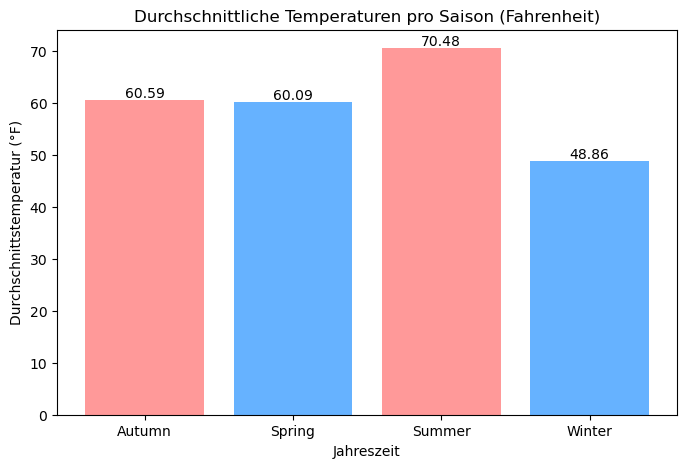

In [18]:
import matplotlib.pyplot as plt

# Visualisierung der durchschnittlichen Temperaturen pro Saison
seasonal_avg_temp = df.groupby('season')['avg_temp_c'].mean().round(2)
seasons = seasonal_avg_temp.index
avg_temps = seasonal_avg_temp.values

plt.figure(figsize=(8, 5))
plt.bar(seasons, avg_temps, color=['#FF9999', '#66B2FF'])
plt.title('Durchschnittliche Temperaturen pro Saison (Fahrenheit)')
plt.xlabel('Jahreszeit')
plt.ylabel('Durchschnittstemperatur (°F)')
for i, v in enumerate(avg_temps):
    plt.text(i, v + 0.5, str(v), ha='center')
plt.show()

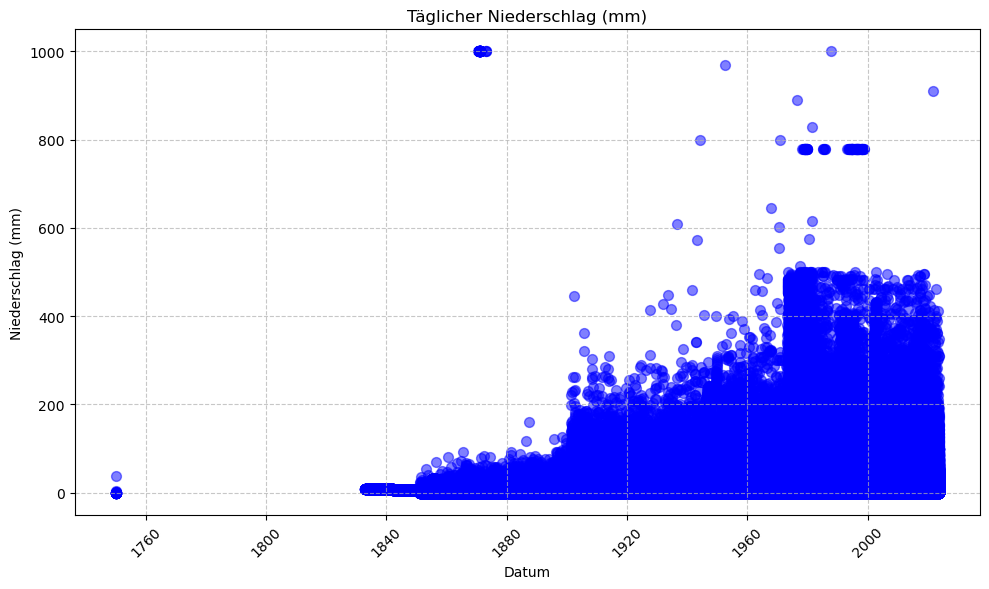

In [20]:
# Visualisierung des täglichen Niederschlags über die Zeit
dates = df['date']
precip = df['precipitation_mm']

plt.figure(figsize=(10, 6))
plt.scatter(dates, precip, color='blue', alpha=0.5, s=50)
plt.title('Täglicher Niederschlag (mm)')
plt.xlabel('Datum')
plt.ylabel('Niederschlag (mm)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 9. Interaktives Liniendiagramm zur Temperaturentwicklung

In [ ]:
import plotly.express as px

# Interaktives Liniendiagramm zur Temperaturentwicklung
fig = px.line(df, x='date', y='avg_temp_f', color='season', 
              title='Temperaturentwicklung über die Zeit (Fahrenheit)',
              labels={'date': 'Datum', 'avg_temp_f': 'Durchschnittstemperatur (°F)', 'season': 'Jahreszeit'})
fig.update_layout(xaxis_title="Datum", yaxis_title="Durchschnittstemperatur (°F)", 
                  legend_title="Jahreszeit", hovermode="x unified")
fig.show()

ModuleNotFoundError: No module named 'plotly'

In [ ]:
import plotly.express as px

# Schritt 9: Interaktives Streudiagramm zur Analyse von Temperatur und Niederschlag
fig = px.scatter(df, x='avg_temp_f', y='precipitation_mm', 
                 color='season', size='max_temp_c',
                 title='Temperatur vs. Niederschlag (Fahrenheit)',
                 labels={'avg_temp_f': 'Durchschnittstemperatur (°F)', 
                         'precipitation_mm': 'Niederschlag (mm)', 
                         'season': 'Jahreszeit', 
                         'max_temp_f': 'Maximale Temperatur (°F)'},
                 hover_data=['date', 'city_name'])  # Zusätzliche Infos beim Hovern
fig.update_layout(xaxis_title="Durchschnittstemperatur (°F)", 
                  yaxis_title="Niederschlag (mm)", 
                  legend_title="Jahreszeit", 
                  hovermode="closest")
fig.show()

c:\Users\Teilnehmer\anaconda4\envs\my_env\python.exe


## 10. Auswertung von zusätzlichen Wetterparametern

C:\Users\Teilnehmer\AppData\Local\Temp\ipykernel_10184\3100295556.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seasonal_weather_stats = df.groupby('season')[weather_params].agg(['mean', 'median', 'std']).round(2)



Statistiken für Wetterparameter pro Saison (Mittelwert, Median, Standardabweichung):
       precipitation_mm              
                   mean median    std
season                               
Autumn             3.65    0.0  12.50
Spring             3.18    0.0  11.15
Summer             4.36    0.0  13.71
Winter             2.66    0.0  10.60


<Figure size 800x500 with 0 Axes>

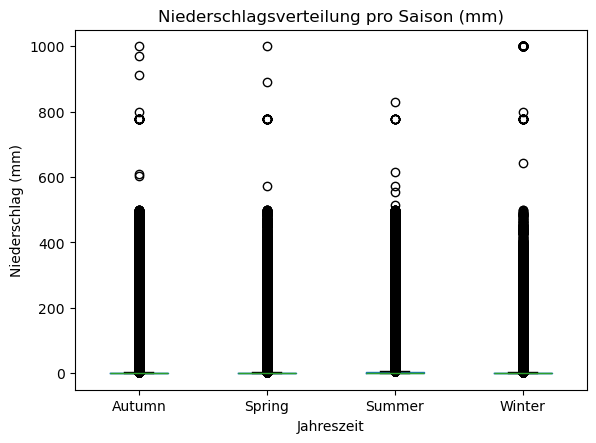

In [29]:

import matplotlib.pyplot as plt

# Auswertung von zusätzlichen Wetterparametern
# Parameter für die Auswertung (Niederschlag und hypothetische Luftfeuchtigkeit)
weather_params = ['precipitation_mm']  # Niederschlag ist vorhanden
# Falls Luftfeuchtigkeit verfügbar wäre, z. B.: weather_params = ['precipitation_mm', 'humidity']

# Statistische Auswertung pro Saison
seasonal_weather_stats = df.groupby('season')[weather_params].agg(['mean', 'median', 'std']).round(2)

print("\nStatistiken für Wetterparameter pro Saison (Mittelwert, Median, Standardabweichung):")
print(seasonal_weather_stats)

# Visualisierung: Boxplot für Niederschlag pro Saison
plt.figure(figsize=(8, 5))
df.boxplot(column='precipitation_mm', by='season', grid=False)
plt.title('Niederschlagsverteilung pro Saison (mm)')
plt.xlabel('Jahreszeit')
plt.ylabel('Niederschlag (mm)')
plt.suptitle('')  # Entfernt den Standardtitel von boxplot
plt.show()

C:\Users\Teilnehmer\AppData\Local\Temp\ipykernel_10184\558040903.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seasonal_weather_stats = df.groupby('season')[weather_params].agg(['mean', 'median', 'std']).round(2)



Statistiken für Wetterparameter pro Saison (Mittelwert, Median, Standardabweichung):
       precipitation_mm               humidity              
                   mean median    std     mean median    std
season                                                      
Autumn             3.65    0.0  12.50    50.01  50.01  17.32
Spring             3.18    0.0  11.15    50.01  50.01  17.32
Summer             4.36    0.0  13.71    49.99  49.99  17.33
Winter             2.66    0.0  10.60    50.00  50.00  17.32


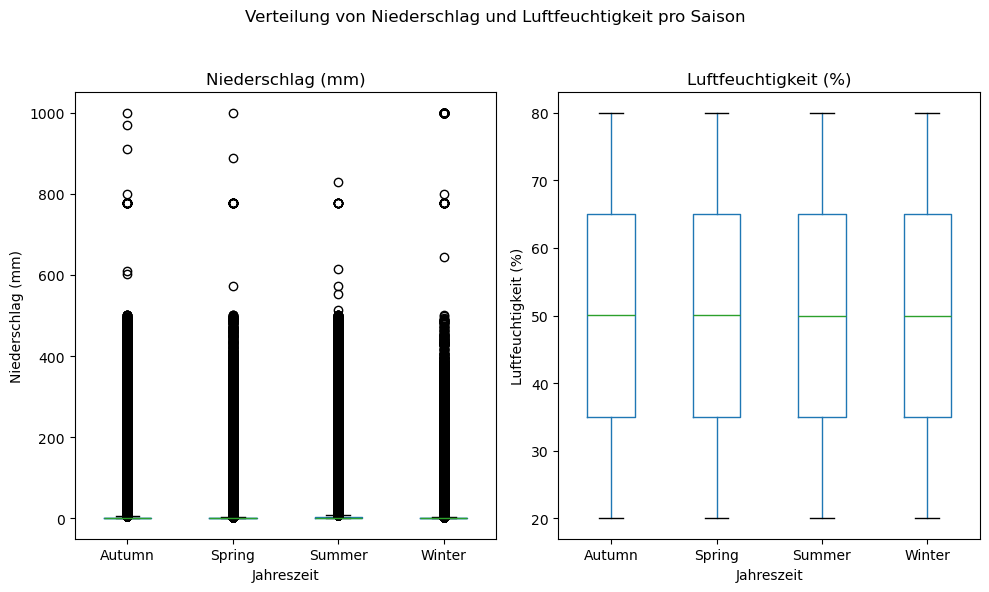

In [35]:
# Hypothetische Luftfeuchtigkeitsspalte hinzufügen (Platzhalter, falls nicht vorhanden)
if 'humidity' not in df.columns:
    # Zufällige Werte zwischen 20% und 80% für Demonstration
    df['humidity'] = np.random.uniform(20, 80, size=len(df))

# Schritt 10: Auswertung von zusätzlichen Wetterparametern
# Parameter für die Auswertung
weather_params = ['precipitation_mm', 'humidity']

# Statistische Auswertung pro Saison
seasonal_weather_stats = df.groupby('season')[weather_params].agg(['mean', 'median', 'std']).round(2)

print("\nStatistiken für Wetterparameter pro Saison (Mittelwert, Median, Standardabweichung):")
print(seasonal_weather_stats)

# Visualisierung: Boxplot für Niederschlag und Luftfeuchtigkeit pro Saison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))  # Zwei Unterdiagramme nebeneinander

# Boxplot für Niederschlag
df.boxplot(column='precipitation_mm', by='season', ax=ax1, grid=False)
ax1.set_title('Niederschlag (mm)')
ax1.set_xlabel('Jahreszeit')
ax1.set_ylabel('Niederschlag (mm)')

# Boxplot für Luftfeuchtigkeit
df.boxplot(column='humidity', by='season', ax=ax2, grid=False)
ax2.set_title('Luftfeuchtigkeit (%)')
ax2.set_xlabel('Jahreszeit')
ax2.set_ylabel('Luftfeuchtigkeit (%)')

# Gesamtüberschrift und Layout anpassen
plt.suptitle('Verteilung von Niederschlag und Luftfeuchtigkeit pro Saison', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Platz für den Titel lassen
plt.show()


Korrelation zwischen Durchschnittstemperatur und Niederschlag: 0.09


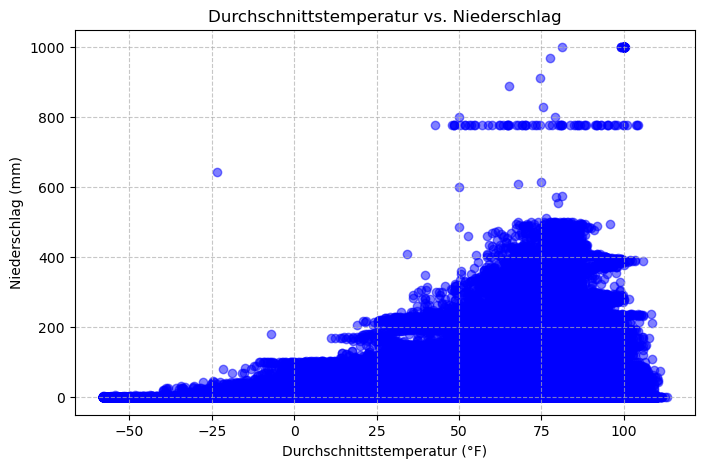

In [37]:


# Korrelation berechnen
correlation = df['avg_temp_c'].corr(df['precipitation_mm']).round(2)
print(f"\nKorrelation zwischen Durchschnittstemperatur und Niederschlag: {correlation}")

# Streudiagramm zur Visualisierung
plt.figure(figsize=(8, 5))
plt.scatter(df['avg_temp_c'], df['precipitation_mm'], alpha=0.5, c='blue')
plt.title('Durchschnittstemperatur vs. Niederschlag')
plt.xlabel('Durchschnittstemperatur (°F)')
plt.ylabel('Niederschlag (mm)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [38]:
# Schwellenwerte definieren
temp_threshold = 100  # °F
precip_threshold = 3  # mm

# Extreme Tage filtern
extreme_hot = df[df['max_temp_c'] > temp_threshold]
extreme_rain = df[df['precipitation_mm'] > precip_threshold]

print("\nTage mit extrem hohen Temperaturen (> 100°F):")
print(extreme_hot[['date', 'city_name', 'max_temp_c', 'precipitation_mm']])
print("\nTage mit starkem Niederschlag (> 3 mm):")
print(extreme_rain[['date', 'city_name', 'max_temp_c', 'precipitation_mm']])


Tage mit extrem hohen Temperaturen (> 100°F):
            date city_name  max_temp_c  precipitation_mm
3     1957-07-04  Asadabad      100.04          4.100000
4     1957-07-05  Asadabad      107.06          0.000000
5     1957-07-06  Asadabad      105.98          0.000000
6     1957-07-07  Asadabad      102.92          0.000000
7     1957-07-08  Asadabad      102.02          0.000000
...          ...       ...         ...               ...
21645 2016-02-20  Masvingo      100.04          0.000000
21646 2016-02-21  Masvingo      102.20          0.000000
21880 2016-10-31  Masvingo      100.40          0.000000
22810 2019-10-26  Masvingo      101.30          3.286996
22812 2019-10-28  Masvingo      101.12          3.134529

[738407 rows x 4 columns]

Tage mit starkem Niederschlag (> 3 mm):
            date city_name  max_temp_c  precipitation_mm
3     1957-07-04  Asadabad      100.04               4.1
43    1957-08-13  Asadabad       89.96               6.1
53    1957-08-23  Asadabad    


Monatliche Durchschnittswerte:
       avg_temp_c  precipitation_mm
month                              
1           48.86              3.02
2           50.61              3.00
3           55.03              3.04
4           60.36              3.21
5           64.93              3.56
6           68.28              3.88
7           70.10              4.05
8           69.51              4.04
9           65.81              3.88
10          60.87              3.50
11          55.07              3.30
12          50.45              3.08


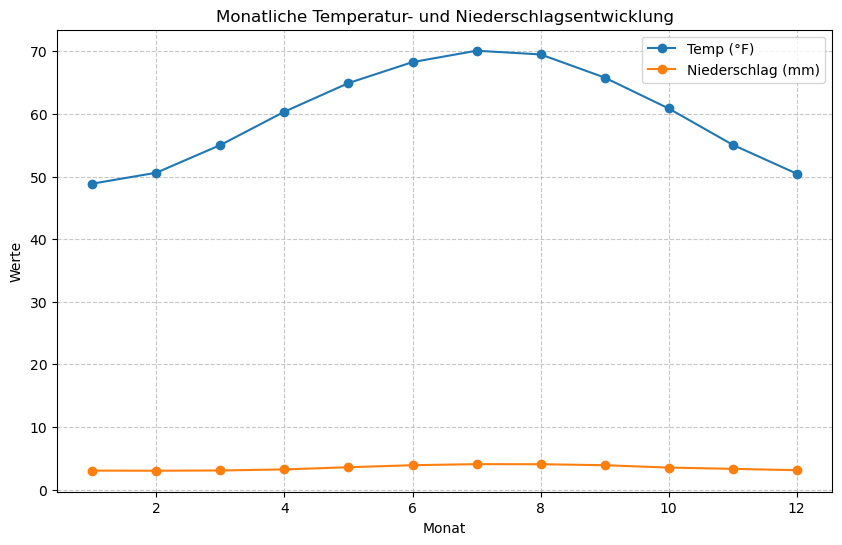

In [39]:
# Monat hinzufügen
df['month'] = df['date'].dt.month

# Monatliche Durchschnittswerte
monthly_stats = df.groupby('month')[['avg_temp_c', 'precipitation_mm']].mean().round(2)

print("\nMonatliche Durchschnittswerte:")
print(monthly_stats)

# Visualisierung: Linienplot
plt.figure(figsize=(10, 6))
plt.plot(monthly_stats.index, monthly_stats['avg_temp_c'], marker='o', label='Temp (°F)')
plt.plot(monthly_stats.index, monthly_stats['precipitation_mm'], marker='o', label='Niederschlag (mm)')
plt.title('Monatliche Temperatur- und Niederschlagsentwicklung')
plt.xlabel('Monat')
plt.ylabel('Werte')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()